# **Part 1 - Data Preprocessing**

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate, LSTM
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding

**1.1 Loading the Data**

In [2]:
with open('train_qa.txt', 'rb') as f:
  train_data = pickle.load(f) #using pickle to load in the training file, read in as binary

with open('test_qa.txt', 'rb') as f:
  test_data = pickle.load(f) #using pickle to load in the test file, read in as binary

type(train_data) #see it's a list

list

In [3]:
print(len(train_data)) #10000 data points broken up into story,question,answer
print(len(test_data)) #1000 data points broken up into story,question,answer

10000
1000


In [4]:
#so here we can see this tuple has 3 main components: story, question, answer
print(' '.join(train_data[0][0])) #index 0 is the story
print(' '.join(train_data[0][1])) #index 1 is the question
print(train_data[0][2]) #index 2 is the answer

Mary moved to the bathroom . Sandra journeyed to the bedroom .
Is Sandra in the hallway ?
no


In [5]:
#Next step we'll want to grab all the unique words
all_data = test_data + train_data #concatenating our test data with our train data
all_data_np = np.array(all_data) #converting all our data into a numpy array
all_data_np.shape #notice the shape of the numpy array is 11000 rows (10000 train + 1000 test data points) and 3 columns (story, question, answer)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


(11000, 3)

**1.2 Grabbing the Vocabulary**

In [6]:
vocab = set() #initializing vocab. set removes duplicates and only returns each distinct element once 

#Now we're going to grab all the unique vocabulary
for story, question, answer in all_data:
  vocab = vocab.union(set(story)) #set removes duplicates
  vocab = vocab.union(set(question)) #union just allows us to join the different sets together. So far, we have a set for story and an initialized set, so now we're using union to add our question set to vocab. https://www.w3schools.com/python/ref_set_union.asp

vocab.add('no')
vocab.add('yes')

In [7]:
print(' '.join(vocab)) #showing all the different vocabulary in one line
print(len(vocab)) #see how there are only 37 unique words in total
#note that means when creating new sentences and predictions, only these 37 words can be used. No new words can be introduced, as the model was not trained on them

football moved Is no . left up in milk kitchen John yes got grabbed dropped Mary to discarded bathroom took Sandra garden office there put went bedroom travelled down journeyed the apple Daniel hallway ? back picked
37


In [8]:
vocab_size = len(vocab) + 1 #adding 1 cuz keras padding needs an extra one to hold a zero
vocab_size

38

**1.3 Longest Story and Longest Question**

In [9]:
#Longest Story
all_story_lens = [len(data[0]) for data in all_data] #data[0] is the story, data[1] is the question, data[2] is the answer
max_story_len = max(all_story_lens) 
max_story_len #156 is the longest story

#so we need the longest length because the RNN requires the text inputs to be the same length. As such, for the shorter stories, we'll use padding sequences to pad the text with 0s until it reaches the max story length

156

In [10]:
#Longest Question
all_question_lens = [len(question) for story, question, answer in all_data] #could've also just used tuple unpacking in contrast to above
max_question_len = max(all_question_lens) 
max_question_len #6 is the longest question

#so we need the longest length because the RNN requires the text inputs to be the same length. As such, for the shorter questions, we'll use padding sequences to pad the text with 0s until it reaches the max question length

6

# **Part 2 - Vectorizing the Data**

**2.1 Tokenizing Data**

In [11]:
#creating an integer encoding our sequence of words
tokenizer = Tokenizer(filters=[]) #creating an instance of our tokenizer imported above
tokenizer.fit_on_texts(vocab) #tokenizing our vocabulator. fitting our vocabulary to the tokenizer, so each word will be assigned a token number 

tokenizer.word_index #dictionary of the word and index, words are all automatically lowercased for us too now

{'.': 5,
 '?': 35,
 'apple': 32,
 'back': 36,
 'bathroom': 19,
 'bedroom': 27,
 'daniel': 33,
 'discarded': 18,
 'down': 29,
 'dropped': 15,
 'football': 1,
 'garden': 22,
 'got': 13,
 'grabbed': 14,
 'hallway': 34,
 'in': 8,
 'is': 3,
 'john': 11,
 'journeyed': 30,
 'kitchen': 10,
 'left': 6,
 'mary': 16,
 'milk': 9,
 'moved': 2,
 'no': 4,
 'office': 23,
 'picked': 37,
 'put': 25,
 'sandra': 21,
 'the': 31,
 'there': 24,
 'to': 17,
 'took': 20,
 'travelled': 28,
 'up': 7,
 'went': 26,
 'yes': 12}

**2.2 Vectorizing Function**

In [12]:
def vectorize(data, word_index = tokenizer.word_index, max_story_len = max_story_len, max_question_len = max_question_len):
  X = [] #X = stories
  Xq = [] #Xq = questions
  Y = [] #Y = answer

  for story, question, answer in data:
    #so for each story and question, first we're lowercasing each word, then we're converting each word into its tokenized index rather than appending the string
    #for example word_index['apple'] will return the token index of 3 rather than the word apple
    x = [word_index[word.lower()] for word in story] #lowercase x = each individual story entry where each word is replaced by the token index
    xq = [word_index[word.lower()] for word in question] #lowercase xq = each individual question entry where each word is replaced by the token index

    y = np.zeros(len(word_index)+1) #+1 because index 0 is reserved when using pad sequences. So length of all the words is 37, plus padding is equal to 38
    y[word_index[answer]] = 1 #so for this story, appending the answer to this word

    X.append(x) #appending the stories to a list
    Xq.append(xq) #appending the questions to a list
    Y.append(y) #appending all the answers to the questions
  
  return (pad_sequences(sequences = X, maxlen = max_story_len), pad_sequences(sequences = Xq, maxlen = max_question_len), np.array(Y)) 
  #we imported pad_sequences above and all it does it just pad the sequences to the maximum length, such that they can all be the same size which is a requirement when feeding into our RNN. also returning our label

In [13]:
inputs_train, queries_train, answers_train = vectorize(train_data)

inputs_test, queries_test, answers_test = vectorize(test_data)

In [14]:
print(queries_test) #notice the questions are now replaced by their tokenized index and max length is 6. The first word for the ones in the preview is "Is"=3, as expected from a question 
print(tokenizer.word_index['the'], '= the \n', tokenizer.word_index['bedroom'], '= bedroom \n',tokenizer.word_index['is'], '= is')
#so these are just arrays with stories outlining the word index position and word index

[[ 3 11  8 31 10 35]
 [ 3 11  8 31 10 35]
 [ 3 11  8 31 22 35]
 ...
 [ 3 16  8 31 27 35]
 [ 3 21  8 31 22 35]
 [ 3 16  8 31 22 35]]
31 = the 
 27 = bedroom 
 3 = is


In [15]:
sum(answers_test) #so 497 cases of yes (token index 12) and 503 cases of no (token index 4)

array([  0.,   0.,   0.,   0., 503.,   0.,   0.,   0.,   0.,   0.,   0.,
         0., 497.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.])

# **Part 3 - Building the End to End Network**

In [16]:
#so we have 2 inputs: stories and questions. So the encoder needs to understand the story, then a separate question, and then we have to link them together in order to provide a label (yes or no)
#so first we're going to create placeholders using Input to instantiate (create an instance of) a keras tensor
input_sequence = Input(shape = (max_story_len, )) #so creating an instance of Input, which was imported above.
#Shape will be based off max story length and max question length, since stories & questions are our two inputs. 
#We added a comma, because since this is a placeholder, the shape will take in (max_story_len, batch_size) where batch_size is currently unknown, so we'll leave it TBD

question = Input(shape=(max_question_len, ))

In [17]:
vocab_size #recall we defined vocab_size earlier above as the len(vocab) + 1, where the +1 is the padding the zero

38

**3.1 Input Encoder, M**

In [18]:
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim = vocab_size, output_dim = 64)) #picking 64 as output based off the paper and power of 2
input_encoder_m.add(Dropout(0.45)) #dropout 45% to reduce overfitting
#encoder will basically output (samples, story_max_len, embedding_dim)
#just made a network sequence for this encoder

**3.2 Input Encoder, C**

In [19]:
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim = vocab_size, output_dim = max_question_len)) 
input_encoder_c.add(Dropout(0.45)) #dropout 45% to reduce overfitting
# encoder will basically output (samples, story_max_len, max_question_len)
#just made a network sequence for this encoder

**3.3 Question Encoder**

In [20]:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim = vocab_size, output_dim = 64, input_length = max_question_len)) 
question_encoder.add(Dropout(0.45)) #dropout 45% to reduce overfitting
# encoder will basically output (samples, question_max_len, embedding)
#just made a network sequence for this encoder

**3.4 Encoding our Sequences**

In [21]:
#Encoder(Input) --> Encoded 
input_encoded_m = input_encoder_m(input_sequence) #passing in that input sequence placeholder we made above into our input encoder m
input_encoded_c = input_encoder_c(input_sequence) #passing in that input sequence placeholder we made above into our input encoder c
question_encoded = question_encoder(question) #passing in that question sequence placeholder we made above into our question encoder

**3.5 End to End Layer**

In [22]:
#Using a dot product to compute the match between the first input vector sequence and the question
match = dot([input_encoded_m,question_encoded], axes=(2,2)) #multiplying internal question state, U, with memory state, Mi.
match = Activation('softmax')(match) #so applying softmax to the product of U-tranposed and Mi to get the weights, Pi

In [23]:
response = add([match, input_encoded_c]) #calculate the weighted sum, O, by taking the product of weights, Pi, with Ci
response = Permute((2,1))(response) #permuting (converting) to have an output of samples with dimensions query max length by story max length

In [24]:
answer = concatenate([response, question_encoded]) #now we're passing weighted sum, O, plus internal question state, u, by concatenating. In just a End-to-End layer, we'd multiply it with final weight matrix, W, then pass through a softmax to get the final label. However, because we're adding an LSTM and RNN, we do that later.
answer #so see how answer is a Tensorflow tensor, where the shape is (?, 6, 220) where ? = unknown batch size still,

<KerasTensor: shape=(None, 6, 220) dtype=float32 (created by layer 'concatenate')>

**3.6 LSTM and RNN Layer**

In [25]:
#In just a End-to-End layer, we'd multiply the concatenated answer with final weight matrix, W, then pass through a softmax to get the final label. However, because we're adding an LSTM and RNN, we do that later.
answer = LSTM(32)(answer) #adding LSTM layer
answer = Dropout(0.45)(answer)
answer = Dense(vocab_size)(answer) #outputs in the shape of (sample, vocab_size), but we'll just see a 1 on index for yes or no, whereas the rest of the vocabularies will just be 0

answer = Activation('softmax')(answer)

In [26]:
model = Model(inputs = [input_sequence, question], outputs = answer) #creating an instance of our Model which we imported above

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics = 'accuracy')

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 156)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, 64)     2432        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 6, 64)        2432        input_2[0][0]                    
______________________________________________________________________________________________

# **Part 4 - Training our Model**

**4.1 Train the Model**

In [28]:
import time #Gonna try to keep track of how long it takes to train our model

start_time = time.time()

history = model.fit(x = [inputs_train, queries_train], y = answers_train, batch_size = 32, epochs = 250, validation_data = ([inputs_test, queries_test], answers_test)) #recall inputs train was our list created of the word indexes

print(f'Training took {(time.time() - start_time)/60} minutes')

Epoch 1/250
313/313 [==============================] - 8s 18ms/step - loss: 1.2946 - accuracy: 0.4808 - val_loss: 0.6979 - val_accuracy: 0.5030
Epoch 2/250
313/313 [==============================] - 5s 15ms/step - loss: 0.7079 - accuracy: 0.5133 - val_loss: 0.6947 - val_accuracy: 0.5030
Epoch 3/250
313/313 [==============================] - 5s 15ms/step - loss: 0.6972 - accuracy: 0.4990 - val_loss: 0.6932 - val_accuracy: 0.4970
Epoch 4/250
313/313 [==============================] - 5s 16ms/step - loss: 0.6947 - accuracy: 0.4960 - val_loss: 0.6947 - val_accuracy: 0.5030
Epoch 5/250
313/313 [==============================] - 5s 16ms/step - loss: 0.6944 - accuracy: 0.5115 - val_loss: 0.6966 - val_accuracy: 0.4970
Epoch 6/250
313/313 [==============================] - 5s 15ms/step - loss: 0.6945 - accuracy: 0.5005 - val_loss: 0.6933 - val_accuracy: 0.4970
Epoch 7/250
313/313 [==============================] - 5s 15ms/step - loss: 0.6936 - accuracy: 0.5113 - val_loss: 0.6945 - val_accuracy:

**4.2 Save the Model**

In [29]:
filename = 'my_chatbot_250_epochs.h5'
model.save(filename)

# **Part 5 - Evaluating the Model**

**5.1 Plotting Out Training History**

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


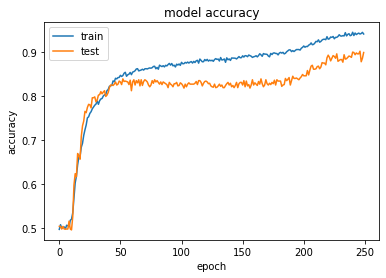

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**5.2 Loading The Model**

In [31]:
model.load_weights('my_chatbot_250_epochs.h5')

**5.3 Evaluating on Given Test Set**

In [32]:
pred_results = model.predict(([inputs_test, queries_test])) #passing in our two test inputs

In [33]:
print(' '.join(test_data[0][0])) #recall entry 0, index 0 is the first story
print(' '.join(test_data[0][1])) #recall entry 0, index 1 is the first question
print(test_data[0][2]) #recall entry 0, index 2 is first answer

Mary got the milk there . John moved to the bedroom .
Is John in the kitchen ?
no


In [34]:
print(pred_results[0]) #notice how it has probabilities for every word, not just yes and no
print(pred_results.shape) #so see the 37 vocab words + 1 for padding, all 37 vocab words have a probability (close to 0 tho except for yes and no)

[3.0161626e-17 3.5168613e-17 3.8314351e-17 2.9720646e-17 9.9967730e-01
 2.5605263e-17 2.5219640e-17 2.9729265e-17 2.4174977e-17 2.7764790e-17
 3.3919004e-17 3.3250646e-17 3.2268927e-04 3.0361684e-17 3.2819039e-17
 2.6714688e-17 3.1879640e-17 2.7216659e-17 3.0434853e-17 2.9166706e-17
 2.5730495e-17 2.6649648e-17 3.1609354e-17 2.7160859e-17 3.3457530e-17
 2.8102363e-17 2.7457551e-17 2.9897924e-17 3.0924749e-17 3.5755842e-17
 3.3182727e-17 2.9424297e-17 2.8695355e-17 3.4550543e-17 2.6811369e-17
 3.9472414e-17 3.1940259e-17 3.1847794e-17]
(1000, 38)


In [35]:
val_max = np.argmax(pred_results[0])

for key,val in tokenizer.word_index.items():
  #just grabbing the key (word index) and val (word) from the dictionary given by .word_index
  if val == val_max:
    k = key

k

'no'

In [36]:
pred_results[0][val_max] #so it was 99.9% sure the answer was no

0.9996773

**5.4 Testing on Our Own Story**

5.4.1 Story 1

In [76]:
my_story = "John travelled to the office . Sandra discarded the apple in the kitchen ."
my_story = my_story.split() #now splitting up each word in my_story
print(my_story)
#print(' '.join(my_story)) 

['John', 'travelled', 'to', 'the', 'office', '.', 'Sandra', 'discarded', 'the', 'apple', 'in', 'the', 'kitchen', '.']


In [77]:
my_question = "Is Sandra in the office ?"
my_question = my_question.split()
my_question

['Is', 'Sandra', 'in', 'the', 'office', '?']

In [78]:
mydata = [(my_story, my_question, 'yes')] #so now adding our story, question, and label into one list

In [79]:
my_story, my_ques, my_ans = vectorize(mydata) #utilizing our vectorize function from above to vectorize our story, question, and answer

my_story #see it's the story replaced with the word indexes, also padded by 0s to meet the max length

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11, 28,
        17, 31, 23,  5, 21, 18, 31, 32,  8, 31, 10,  5]], dtype=int32)

In [80]:
pred_results = model.predict(([my_story, my_ques])) #passing in our two test inputs

val_max = np.argmax(pred_results[0])

for key,val in tokenizer.word_index.items():
  #just grabbing the key (word index) and val (word) from the dictionary given by .word_index
  if val == val_max:
    k = key

print(f"{k} with a {pred_results[0][val_max]*100} probability") #so it was 99.99% sure the answer was no"

no with a 99.99819993972778 probability


5.4.2 Story 2

In [59]:
my_story2 = "Daniel journeyed to the bedroom . Mary grabbed the football in the office ."
my_story2 = my_story2.split() #now splitting up each word in my_story

my_question2 = "Is the football in the office ?"
my_question2 = my_question2.split()

mydata2 = [(my_story2, my_question2, 'yes')] #so now adding our story, question, and label into one list

my_story2, my_ques2, my_ans2 = vectorize(mydata2) #utilizing our vectorize function from above to vectorize our story, question, and answer

pred_results = model.predict(([my_story2, my_ques2])) #passing in our two test inputs

val_max = np.argmax(pred_results[0])

for key,val in tokenizer.word_index.items():
  #just grabbing the key (word index) and val (word) from the dictionary given by .word_index
  if val == val_max:
    k = key

print(f"{k} with a {pred_results[0][val_max]*100} probability") #so it was 53.7% sure the answer was yes"

yes with a 53.699856996536255 probability


5.4.3 Story 3

In [72]:
my_story3 = "Sandra is in the hallway . Daniel picked up apple in the garden ."
my_story3 = my_story3.split() #now splitting up each word in my_story

my_question3 = "Is the apple in the hallway ?"
my_question3 = my_question3.split()

mydata3 = [(my_story3, my_question3, 'no')] #so now adding our story, question, and label into one list

my_story3, my_ques3, my_ans3 = vectorize(mydata3) #utilizing our vectorize function from above to vectorize our story, question, and answer

pred_results = model.predict(([my_story3, my_ques3])) #passing in our two test inputs

val_max = np.argmax(pred_results[0])

for key,val in tokenizer.word_index.items():
  #just grabbing the key (word index) and val (word) from the dictionary given by .word_index
  if val == val_max:
    k = key

print(f"{k} with a {pred_results[0][val_max]*100} probability") #so it was 99% sure the answer was no"

no with a 99.92278814315796 probability
